# Beginning of Project

In [1]:
# imports
import os
import zipfile
import pandas as pd
import pyarrow as pa
import pyarrow.csv
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import streamlit as st
import plotly.express as px
import nbformat

# state codes
non_state_codes = [
    "DC", "PR", "AE", "VI", "AP", "GU", 
    "MP", "AA", "AS", "EN", "GE", "QC", 
    "XX", "NO", "AB", "ZZ"
]
state_codes = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [2]:
# Read ZIP and load CSV using PyArrow
with zipfile.ZipFile("P00000001-ALL.zip", "r") as zip_ref:
    csv_data = zip_ref.read("P00000001-ALL.csv")

cf_df = pa.csv.read_csv(pa.BufferReader(csv_data)).to_pandas()
print("Extracted CSV: P00000001-ALL.csv")

# Filter out non-state contributions and convert date format
cf_df = cf_df[cf_df["contbr_st"].isin(state_codes)]
cf_df["contb_receipt_dt"] = pd.to_datetime(cf_df["contb_receipt_dt"], format="%d-%b-%y")

Extracted CSV: P00000001-ALL.csv


In [3]:
# Analyze donation sizes by ZIP
top_candidates = ["Harris, Kamala", "Trump, Donald J."]
filtered = cf_df[cf_df["cand_nm"].isin(top_candidates)]
zip_grouped = filtered.groupby(['contbr_st', 'contbr_zip'])['contb_receipt_amt'].sum().reset_index()

# Bin donation sizes
bins = [-float('inf'), 100, 200, 1000, float('inf')]
labels = ['<100', '<200', '<1000', '>1000']
zip_grouped['donation_bin'] = pd.cut(zip_grouped['contb_receipt_amt'], bins=bins, labels=labels)

# Count bins by state
binned_counts = zip_grouped.groupby(['contbr_st', 'donation_bin']).size().unstack(fill_value=0)

# View summary table
print("\nDonation Size Distribution by State:")
print(binned_counts.head())


Donation Size Distribution by State:
donation_bin   <100   <200  <1000  >1000
contbr_st                               
AK              447    419   1662    533
AL             1229   1061   3033   1291
AR              878    794   2272    871
AZ             4614   3778  11407   3443
CA            28216  24575  91648  41163


C:\Users\AJV03\AppData\Local\Temp\ipykernel_18104\1211634031.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_counts = zip_grouped.groupby(['contbr_st', 'donation_bin']).size().unstack(fill_value=0)


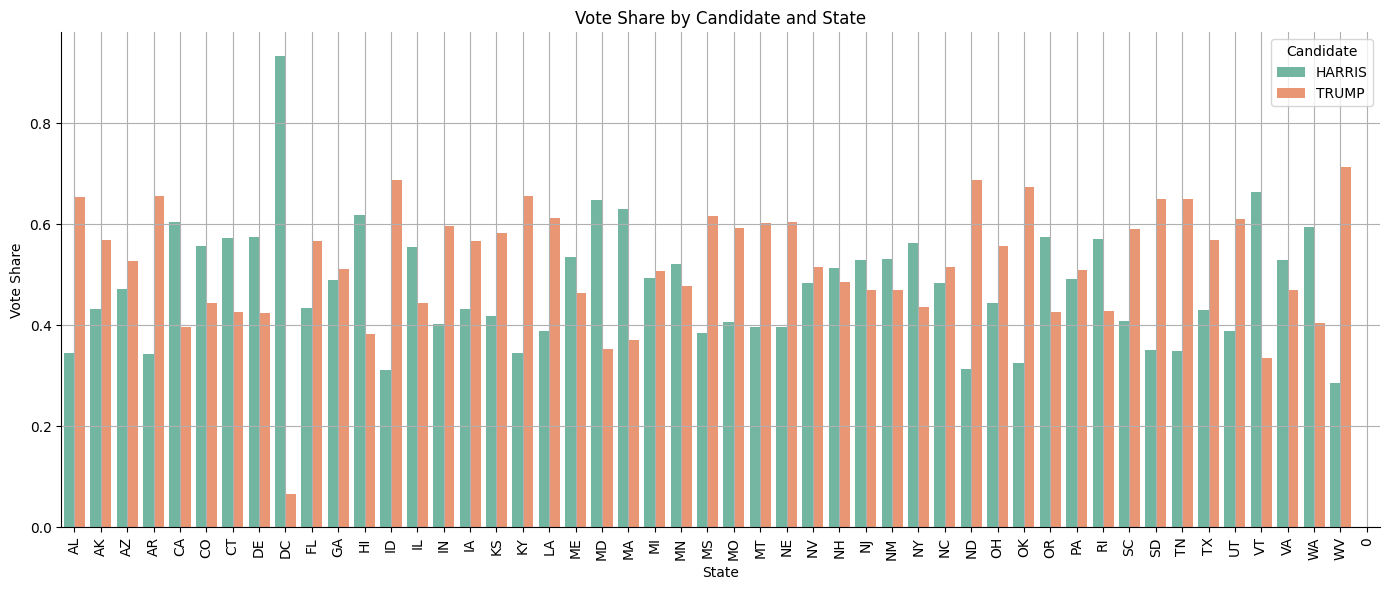

In [ ]:
# Read election results
elec_df = pd.read_excel("2024presgeresults.xlsx")
elec_df.fillna(0, inplace=True)

# Drop minor candidates to match donation focus
irrelevant = ['AYYADURAI', 'BOWMAN', 'DE LA CRUZ', 'DUNCAN', 'EBKE', 'EVERYLOVE', 'FRUIT', 'GARRITY', 'HUBER', 
              'KENNEDY', 'KISHORE', 'OLIVER', 'PRESTON', 'SKOUSEN', 'SONSKI', 'STEIN', 'STODDEN', 'SUPREME', 
              'TERRY', 'WELLS', 'WEST', 'WOOD', 'NONE OF THESE CANDIDATES', 'WRITE-INS (SCATTERED)']
elec_df.drop(columns=irrelevant, inplace=True)

# reformat data for plotting and calculate share of votes
elec_df = elec_df[["STATE", "HARRIS", "TRUMP"]]
elec_df = elec_df.drop(index=elec_df.index[49:73])
elec_df = elec_df.dropna()
harris_share = elec_df["HARRIS"] / (elec_df["HARRIS"] + elec_df["TRUMP"])
trump_share = elec_df["TRUMP"] / (elec_df["HARRIS"] + elec_df["TRUMP"])
elec_df["HARRIS"] = harris_share
elec_df["TRUMP"] = trump_share

elec_df_h = elec_df[["STATE", "HARRIS"]]
elec_df_h["CAND"] = "HARRIS"
elec_df_h.columns = ["STATE", "VOTES", "CAND"]

elec_df_t = elec_df[["STATE", "TRUMP"]]
elec_df_t["CAND"] = "TRUMP"
elec_df_t.columns = ["STATE", "VOTES", "CAND"]

elec_df = pd.concat([elec_df_h, elec_df_t], ignore_index=True)

# plot data
plt.figure(figsize=(14, 6))
sns.barplot(data=elec_df, x="STATE", y="VOTES", hue="CAND", palette="Set2")
sns.despine()
plt.title("Vote Share by Candidate and State")
plt.xlabel("State")
plt.ylabel("Vote Share")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(title="Candidate")
plt.grid()
plt.show()


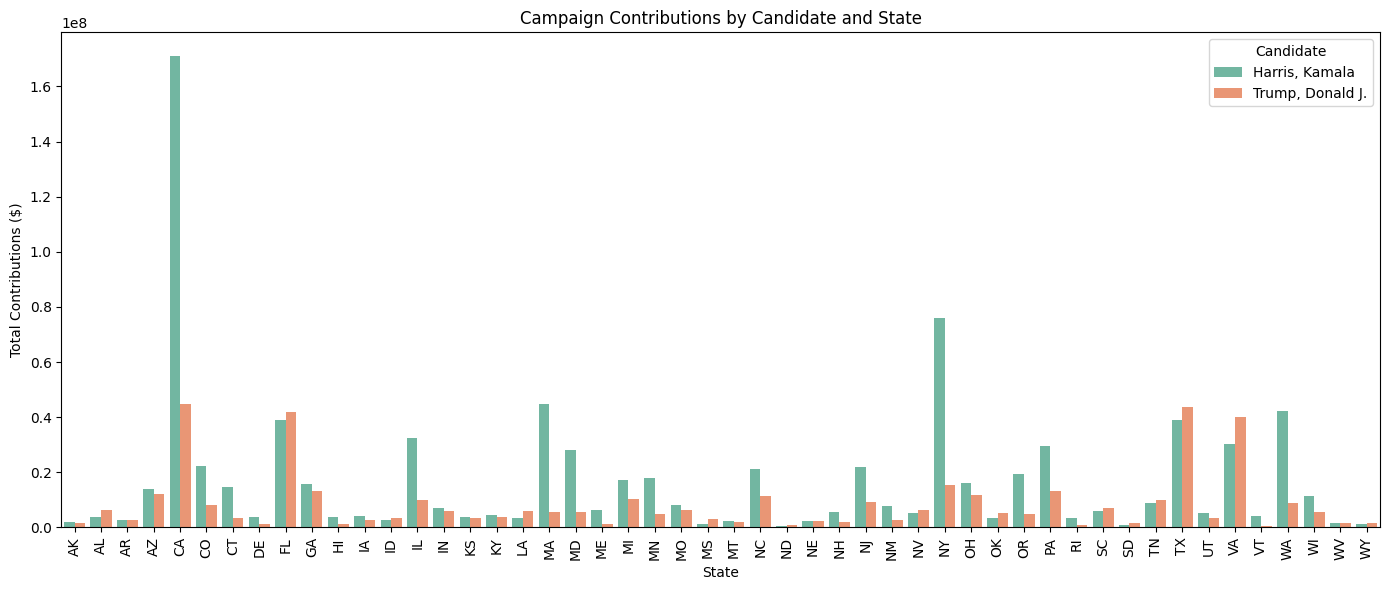

In [ ]:
# Group donations by state, ZIP, and candidate
grouped = cf_df.groupby(["contbr_st", "contbr_zip", "cand_nm"])["contb_receipt_amt"].sum().reset_index()

# Get total by state & candidate
state_cand_sums = grouped.groupby(["contbr_st", "cand_nm"])["contb_receipt_amt"].sum().reset_index()
state_cand_sums = state_cand_sums.sort_values(by=["contbr_st", "contb_receipt_amt"], ascending=[True, False])

# Focus on top candidates (adjust as needed)
top_candidates = ["Harris, Kamala", "Trump, Donald J."]
state_sums = state_cand_sums[state_cand_sums["cand_nm"].isin(top_candidates)].reset_index(drop=True)

# Read election results
elec_df = pd.read_excel("2024presgeresults.xlsx")
elec_df.fillna(0, inplace=True)

# Drop minor candidates to match donation focus
irrelevant = ['AYYADURAI', 'BOWMAN', 'DE LA CRUZ', 'DUNCAN', 'EBKE', 'EVERYLOVE', 'FRUIT', 'GARRITY', 'HUBER', 
              'KENNEDY', 'KISHORE', 'OLIVER', 'PRESTON', 'SKOUSEN', 'SONSKI', 'STEIN', 'STODDEN', 'SUPREME', 
              'TERRY', 'WELLS', 'WEST', 'WOOD', 'NONE OF THESE CANDIDATES', 'WRITE-INS (SCATTERED)']
elec_df.drop(columns=irrelevant, inplace=True)

# Merge contributions with vote data
merged_df = pd.merge(state_sums, elec_df, left_on="contbr_st", right_on="STATE", how="inner").drop("STATE", axis=1)

# 📊 Plot contributions by state and candidate
plt.figure(figsize=(14, 6))
sns.barplot(data=elec_df, x="contbr_st", y="contb_receipt_amt", hue="cand_nm", palette="Set2")
plt.title("Campaign Contributions by Candidate and State")
plt.xlabel("State")
plt.ylabel("Total Contributions ($)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(title="Candidate")
plt.show()

In [6]:
merged_df

,contbr_st,cand_nm,contb_receipt_amt,ELECTORAL VOTES,ELECTORAL VOTE: TRUMP (R),ELECTORAL VOTE: HARRIS (D),HARRIS,TRUMP,TOTAL VOTES
0,AK,"Harris, Kamala",2000104.10,3,3.0,0.0,140026.0,184458.0,338177.0
1,AK,"Trump, Donald J.",1483484.02,3,3.0,0.0,140026.0,184458.0,338177.0
2,AL,"Trump, Donald J.",6320914.06,9,9.0,0.0,772412.0,1462616.0,2265090.0
3,AL,"Harris, Kamala",3680451.30,9,9.0,0.0,772412.0,1462616.0,2265090.0
4,AR,"Trump, Donald J.",2873684.13,6,6.0,0.0,396905.0,759241.0,1182676.0
...,...,...,...,...,...,...,...,...,...
95,WI,"Trump, Donald J.",5495803.10,10,10.0,0.0,1668229.0,1697626.0,3422918.0
96,WV,"Trump, Donald J.",1534076.74,4,4.0,0.0,214309.0,533556.0,762582.0
97,WV,"Harris, Kamala",1515948.81,4,4.0,0.0,214309.0,533556.0,762582.0
98,WY,"Trump, Donald J.",1625484.86,3,3.0,0.0,69527.0,192633.0,269048.0


In [ ]:
# Group all non-Harris/Trump as "Other"
cf_df["cand_group"] = cf_df["cand_nm"].apply(
    lambda name: name if name in ["Harris, Kamala", "Trump, Donald J."] else "Other"
)

# Extract month and group by month + candidate group
cf_df["month"] = cf_df["contb_receipt_dt"].dt.to_period("M").astype(str)
monthly_grouped = cf_df.groupby(["month", "cand_group"])["contb_receipt_amt"].sum().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_grouped, x="month", y="contb_receipt_amt", hue="cand_group")
sns.despine()
plt.title("Monthly Donation Totals by Candidate Group")
plt.xlabel("Month")
plt.ylabel("Total Contributions ($ Millions)")
plt.legend(title="Candidates")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000000)}'))
plt.tight_layout()
plt.show()

In [ ]:
# donations by zip code
# works but looks gross at zip code level
# outdated

# import geopandas as gpd
# import pandas as pd
# import plotly.express as px
# import json

# # 1. Load shapefile and simplify geometry
# zcta = gpd.read_file("zip_shapefile_data/zcta_simplified.geojson")
# zcta = zcta[["ZCTA5CE20", "geometry"]].rename(columns={"ZCTA5CE20": "zip"})
# zcta["zip"] = zcta["zip"].astype(str)

# # Filter to only ZIPs in your dataset
# zip_codes = cf_df["contbr_zip"].dropna().astype(str).unique()
# zcta = zcta[zcta["zip"].isin(zip_codes)].copy()
# zcta.loc[:, "geometry"] = zcta["geometry"].simplify(0.01)

# # 2. Aggregate donations by ZIP
# don_by_zip = cf_df.groupby("contbr_zip")["contb_receipt_amt"].sum().reset_index()
# don_by_zip = don_by_zip.rename(columns={"contbr_zip": "zip"})
# don_by_zip["zip"] = don_by_zip["zip"].astype(str)

# # 3. Merge with geometry
# choropleth_df = zcta.merge(don_by_zip, on="zip", how="left").fillna(0)
# choropleth_df["id"] = choropleth_df.index.astype(str)

# # 4. Convert GeoDataFrame to GeoJSON
# geojson_data = json.loads(choropleth_df.to_json())

# # 5. Use new plotly.express.choropleth_map (MapLibre)
# fig = px.choropleth_map(
#     choropleth_df,
#     geojson=geojson_data,
#     locations="id",
#     featureidkey="properties.id",
#     color="contb_receipt_amt",
#     hover_name="zip",
#     color_continuous_scale="Viridis",
#     range_color=(0, choropleth_df["contb_receipt_amt"].max()),
#     center={"lat": 37.8, "lon": -96},
#     zoom=3,
#     height=600
# )

# fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
# fig.show()


In [ ]:
# donations by county
# works

import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import requests
import zipfile
import numpy as np
import streamlit as st


# --- HUD API SETUP ---
API_KEY = st.secrets["hud_api_key"]
headers = {"Authorization": f"Bearer {API_KEY}"}
url = "https://www.huduser.gov/hudapi/public/usps?type=2&query=All"  # ZIP → County

# --- Load campaign finance data ---
def load_data():
    with zipfile.ZipFile("P00000001-ALL.zip", "r") as zip_ref:
        csv_data = zip_ref.read("P00000001-ALL.csv")
    df = pa.csv.read_csv(pa.BufferReader(csv_data)).to_pandas()
    state_codes = [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA",
        "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
        "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT",
        "VA", "WA", "WV", "WI", "WY"
        ]
    df = df[df["contbr_st"].isin(state_codes)]
    df["contb_receipt_dt"] = pd.to_datetime(df["contb_receipt_dt"], format="%d-%b-%y")
    df = df[df["contb_receipt_amt"] > 0]  # remove negative donations (outflows)
    return df

def load_zip_to_county_crosswalk():
    API_KEY = st.secrets["hud_api_key"]
    headers = {"Authorization": f"Bearer {API_KEY}"}
    url = "https://www.huduser.gov/hudapi/public/usps?type=2&query=All"
    response = requests.get(url, headers=headers)
    df = pd.DataFrame(response.json()["data"]["results"])
    df["zip"] = df["zip"].astype(str)
    df["geoid"] = df["geoid"].astype(str)
    df = df.sort_values("tot_ratio", ascending=False)
    df = df.drop_duplicates("zip")  # Keep only top county per ZIP
    return df

cf_df = load_data()
cf_df["contbr_zip"] = cf_df["contbr_zip"].astype(str).str[:5].str.zfill(5)
crosswalk_df = load_zip_to_county_crosswalk()
crosswalk_df["zip"] = crosswalk_df["zip"].astype(str).str[:5].str.zfill(5)

merged_df = cf_df.copy()
merged_df["contbr_zip"] = merged_df["contbr_zip"].astype(str)
merged_df = merged_df.merge(crosswalk_df[["zip", "geoid"]], left_on="contbr_zip", right_on="zip", how="left")
merged_df = merged_df.rename(columns={"geoid": "GEOID"})

counties = gpd.read_file("county_shapefile_data/counties_simplified.geojson")
counties = counties[["GEOID", "NAMELSAD", "geometry"]].copy()
counties["GEOID"] = counties["GEOID"].astype(str)

county_donations = merged_df.groupby("GEOID")["contb_receipt_amt"].sum().reset_index()
choropleth_df = counties.merge(county_donations, on="GEOID", how="left").fillna(0)
choropleth_df["log_donations"] = np.where(
    choropleth_df["contb_receipt_amt"] > 0,
    np.log10(choropleth_df["contb_receipt_amt"] + 1),
    0
)
color_col = "log_donations"
color_scale = "Viridis"
color_title = "Donations ($)"

fig = px.choropleth_map(
            choropleth_df,
            geojson=json.loads(choropleth_df.to_json()),
            locations="GEOID",
            featureidkey="properties.GEOID",
            color=color_col,
            hover_data=["NAMELSAD", "contb_receipt_amt"],
            color_continuous_scale=color_scale,
            center={"lat": 37.8, "lon": -96},
            zoom=3,
            height=600
        )

fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    coloraxis_colorbar_title="Donations ($)",
    coloraxis_colorbar_tickformat=".2f"
)

fig.update_traces(marker_line_width=1.0, marker_line_color="black")

fig.show()

In [ ]:
pivot = merged_df[merged_df["cand_nm"].isin(["Trump, Donald J.", "Harris, Kamala"])]
pivot = pivot.groupby(["GEOID", "cand_nm"])["contb_receipt_amt"].sum().unstack(fill_value=0).reset_index()
pivot["kamala_ratio"] = pivot["Harris, Kamala"] / (pivot["Harris, Kamala"] + pivot["Trump, Donald J."])
pivot["kamala_ratio"] = pivot["kamala_ratio"].fillna(0.5)  # Treat 0/0 as neutral purple(pivot["diff"] + max_abs) / (2 * max_abs)  # Normalize to [0,1] for red-purple-blue scale
choropleth_df = counties.merge(pivot, on="GEOID", how="left")
color_col = "kamala_ratio"
color_scale = [(0.0, "red"), (0.5, "purple"), (1.0, "blue")]  # red = Trump > Kamala, blue = Kamala > Trump
color_title = "Kamala Share of Donations" # Blue is kamala, red is trump.

fig = px.choropleth_map(
            choropleth_df,
            geojson=json.loads(choropleth_df.to_json()),
            locations="GEOID",
            featureidkey="properties.GEOID",
            color=color_col,
            hover_data=["NAMELSAD", "Harris, Kamala", "Trump, Donald J."],
            color_continuous_scale=color_scale,
            center={"lat": 37.8, "lon": -96},
            zoom=3,
            height=600
        )

fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    coloraxis_colorbar_title=color_title,
    coloraxis_colorbar_tickformat=".2f"
)

fig.update_traces(marker_line_width=0.35, marker_line_color="gray")
